In [97]:
%load_ext autoreload
%autoreload 2

import torch
import tqdm
import gpytorch


import numpy as np
from ase import io
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import sys
sys.path.append("../../fande") # Adds higher directory to python modules path.
sys.path.append("..") # Adds higher directory to python modules path.

In [100]:
path = os.getcwd()

print(path)

/home/dlb/coding/shared_coding/repos/chem-gp/saddle-dynamics/notebooks


In [4]:
from fande.data import FandeDataModule

fande.models module imported...
FandE-GP imported  
objects of fande.data module imported...


### Parsing and loading data:

In [15]:
%load_ext autoreload
%autoreload 2

from sdynamics.load import parse_trajectories, parse_forces, flatten_trj_dictionaries

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
trajectories, energies_trj, trj_files_basenames = parse_trajectories(traj_folder="../data/dynamics/ene_grad_fitting/data/trj/")
forces_trj = parse_forces(forces_path = '../data/dynamics/ene_grad_fitting/data/grad/', trj_files_basenames = trj_files_basenames)

Reading trajectory files...


100%|██████████| 50/50 [00:17<00:00,  2.89it/s]

Trajectory files reading done!
Reading .npy files with forces...
Reading .npy files with forces done!


In [33]:
traj, energies, forces = flatten_trj_dictionaries(trajectories, energies_trj, trj_files_basenames, forces_trj)

Flattening done!


### Prepare training/test datasets:

In [258]:
# Training data:
training_indices = np.sort(  np.random.choice(np.arange(0,92795), 10000, replace=False) ) 
traj_train = [traj[i] for i in training_indices]
energies_train = energies[training_indices]
forces_train = forces[training_indices]
train_data = {'trajectory': traj_train, 'energies': energies_train, 'forces': forces_train}

#Test data:
test_indices = np.sort(  np.random.choice(np.arange(0,92795), 200, replace=False) ) 
traj_test = [traj[i] for i in test_indices]
energies_test = energies[test_indices]
forces_test = forces[test_indices]
test_data = {'trajectory': traj_test, 'energies': energies_test, 'forces': forces_test}

In [259]:
from fande.data import FandeDataModuleASE


hparams = {
    "soap_params" : soap_params,
    'dtype' : 'float64',
    'device' : 'gpu'
}

In [260]:
fdm = FandeDataModuleASE(train_data, test_data, hparams, atoms_forces=None)

In [261]:
soap_params = {
    'species': ["H", "C"],
    'periodic': False,
    'rcut': 5.0,
    'sigma': 0.5,
    'nmax': 5,
    'lmax': 5,
    'average': "outer",
    'crossover': True,
    'dtype': "float64",
    'n_jobs': 10
}

fdm.calculate_invariants(soap_params)

Total length of train traj is 10000
Starting SOAP calculation...
SOAP calculation done!
Total length of test traj is 200
Starting SOAP calculation...
SOAP calculation done!
(10000, 17, 3, 840)
(10000, 840)


In [213]:
fdm.forces_train.shape[1]

1

### Fitting Forces:

In [267]:
from fande.models import ModelForces, ModelEnergies, MyCallbacks
from torch.utils.data import DataLoader, TensorDataset, random_split
from pytorch_lightning import Trainer, seed_everything
import numpy as np
# seed_everything(42, workers=True)

train_DX = fdm.train_DX
train_F = fdm.train_F
test_DX = fdm.test_DX
test_F = fdm.test_F

# ind_slice = np.sort( np.concatenate( 
#     ( np.arange(0,4800), np.arange(11*4800,12*4800), np.random.choice(np.arange(4800,59200), 300, replace=False) ) 
#     ) )

# ind_slice = np.sort(  np.random.choice(np.arange(0,59200), 2000, replace=False) ) 
ind_slice = np.sort(  np.arange(0,2000) ) 

train_dataset = TensorDataset(train_DX[ind_slice], train_F[ind_slice])
train_loader = DataLoader(train_dataset, batch_size=100_000)

model_f = ModelForces(train_DX[ind_slice], train_F[ind_slice], hparams, 0.01)

trainer_f = Trainer(
    gpus=1, 
    max_epochs=1200, 
    precision=64,
    weights_summary='full', 
    callbacks=[MyCallbacks()])

trainer_f.fit(model_f, train_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                                                   | Type                       | Params
------------------------------------------------------------------------------------------------------
0 | likelihood                                             | GaussianLikelihood         | 1     
1 | likelihood.noise_covar                                 | HomoskedasticNoise         | 1     
2 | likelihood.noise_covar.raw_noise_constraint            | GreaterThan                | 0     
3 | likelihood.noise_covar.raw_noise_constraint._transform | Softplus                   | 0     
4 | model                                                  | ExactGPModelForces         | 841   
5 | model.mean_module                                      | ZeroMean                   | 0     
6 | model.covar_module                                     | Mater


 setup() callback called...
Epoch 1199: 100%|██████████| 1/1 [00:00<00:00,  7.56it/s, loss=-2.81, v_num=49]   

 teardown() callback called...


### Predictions on test data:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.




 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...


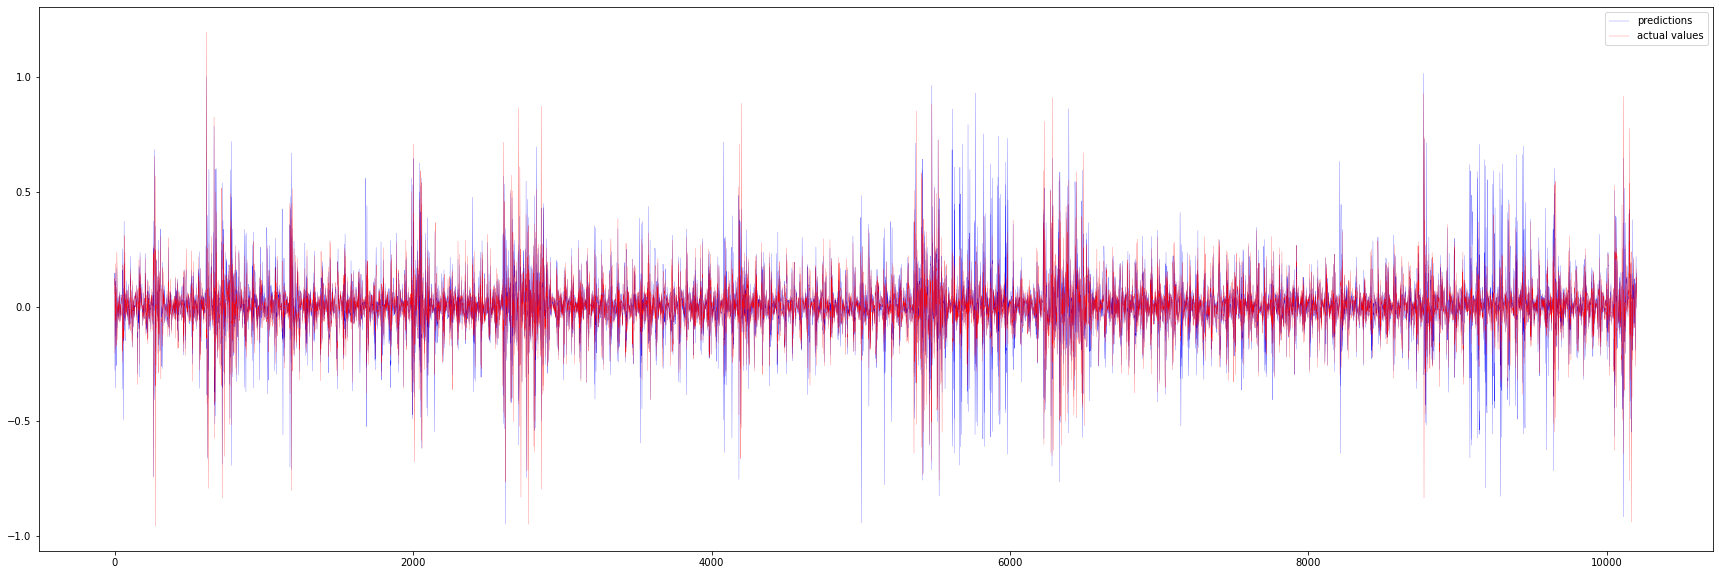

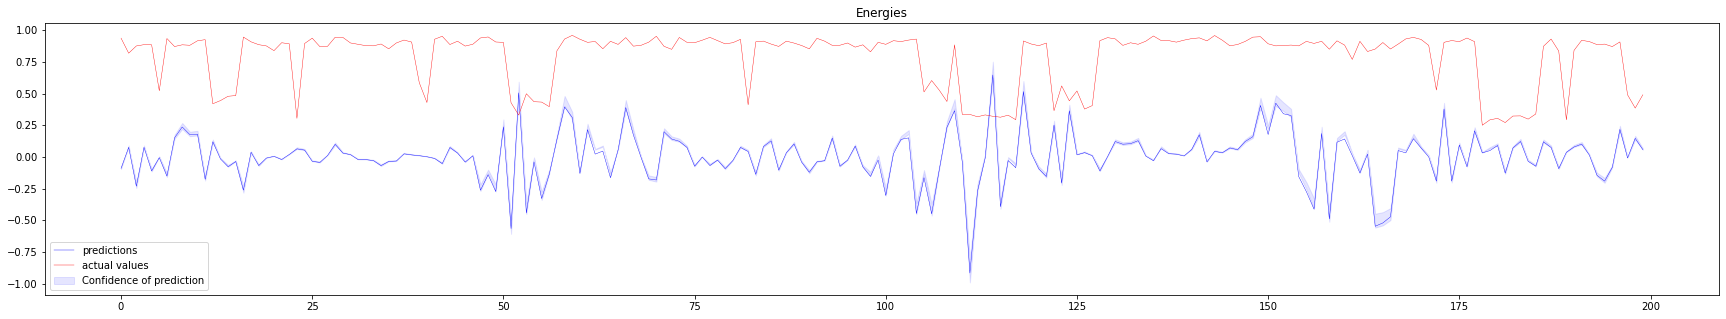

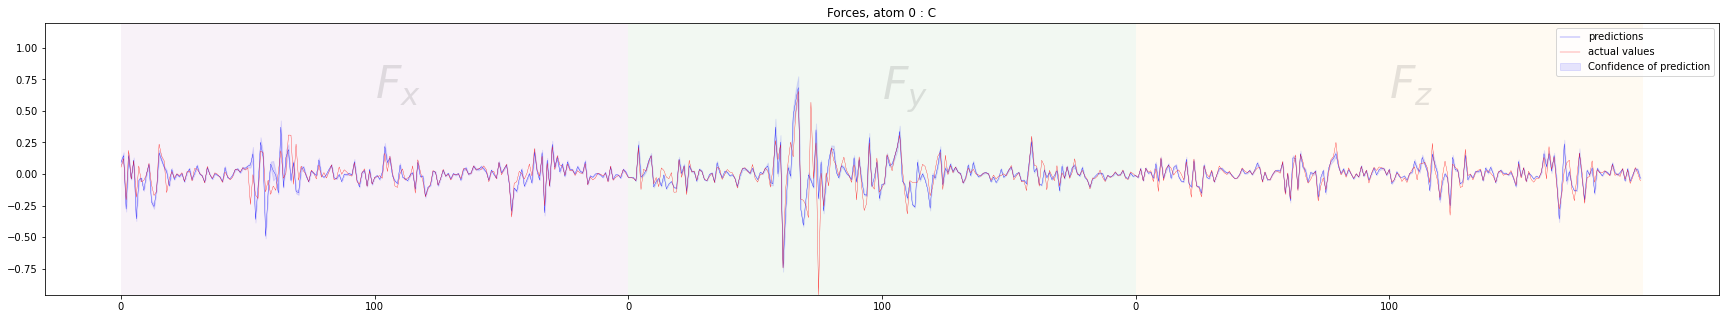

Forces MAE: 0.0371
Forces MSE: 0.0054
Cumulative uncertainty: 8.5001


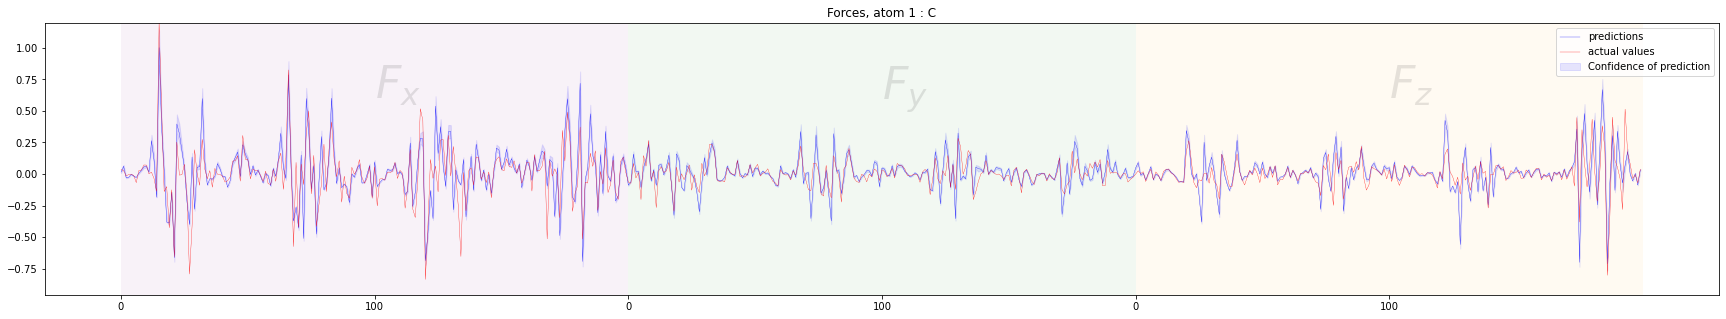

Forces MAE: 0.0708
Forces MSE: 0.0140
Cumulative uncertainty: 15.3035


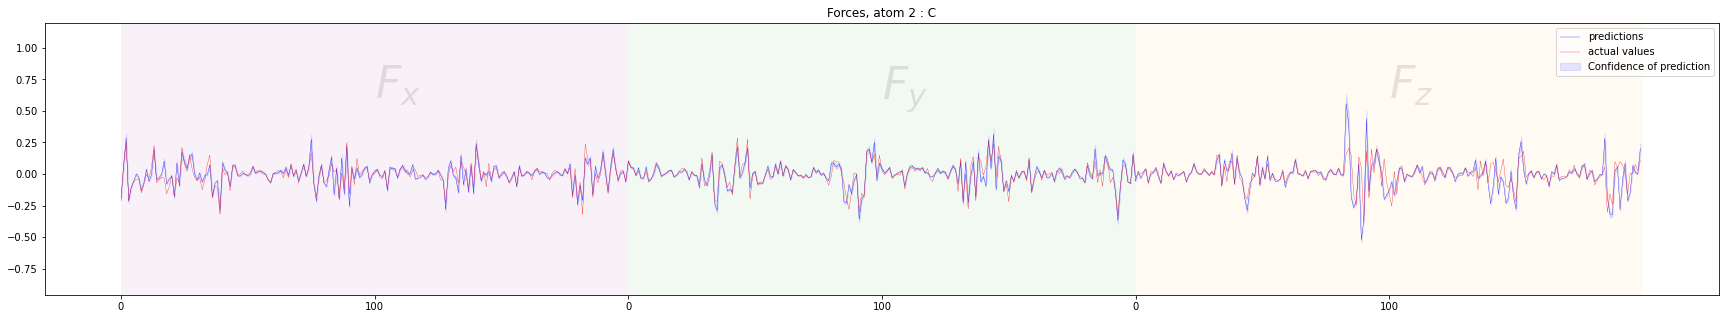

Forces MAE: 0.0332
Forces MSE: 0.0038
Cumulative uncertainty: 7.5940


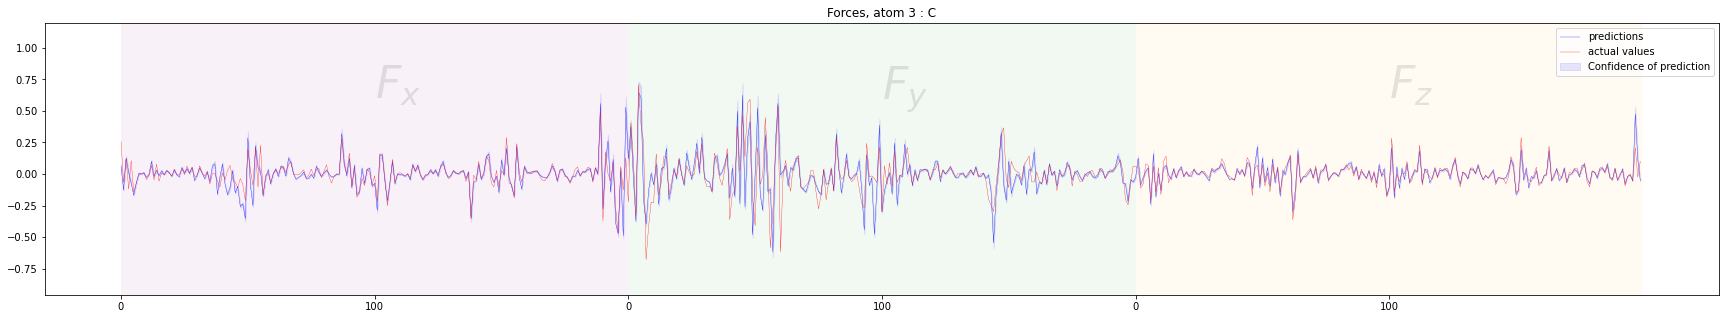

Forces MAE: 0.0481
Forces MSE: 0.0082
Cumulative uncertainty: 9.2566


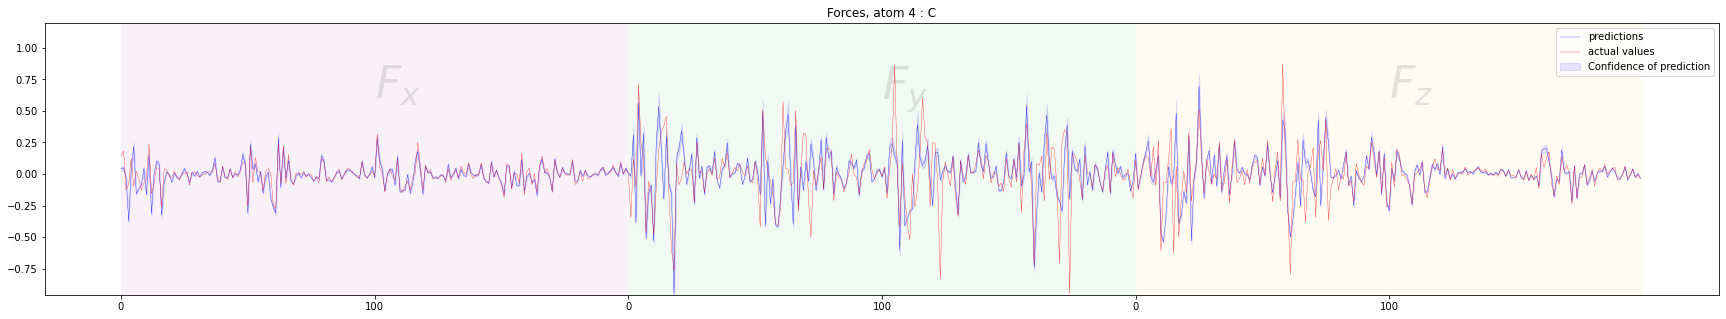

Forces MAE: 0.0745
Forces MSE: 0.0202
Cumulative uncertainty: 13.4549


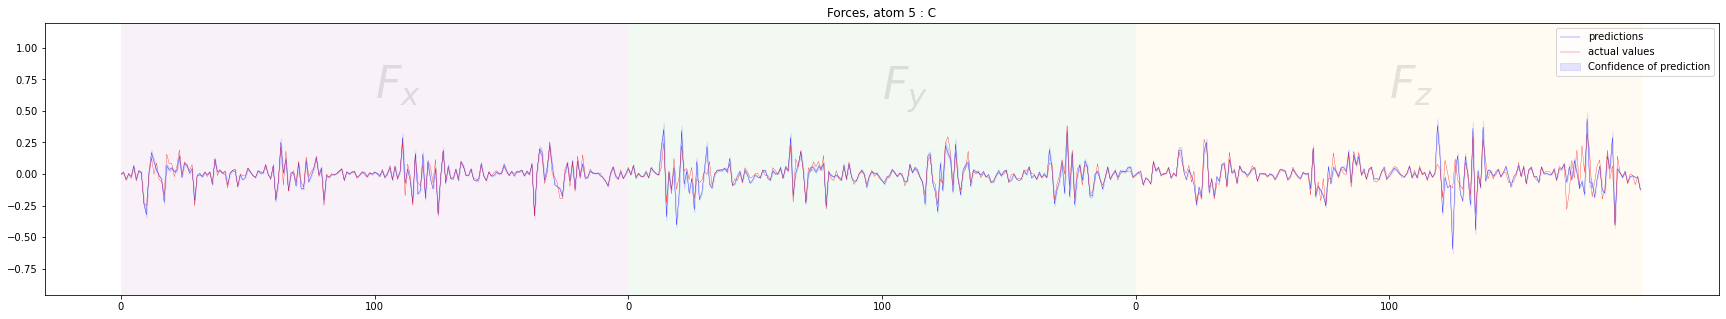

Forces MAE: 0.0305
Forces MSE: 0.0030
Cumulative uncertainty: 6.9253


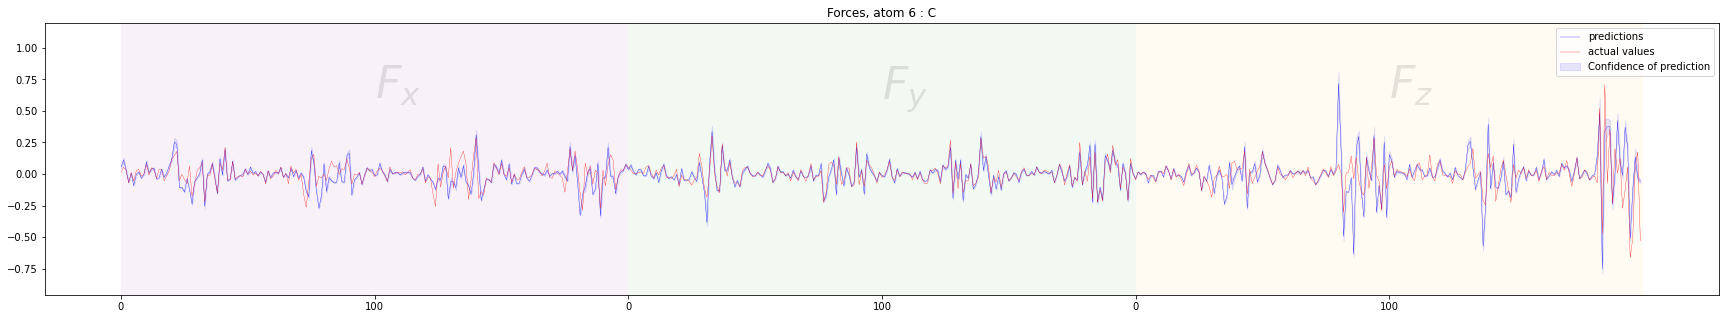

Forces MAE: 0.0468
Forces MSE: 0.0079
Cumulative uncertainty: 9.4551


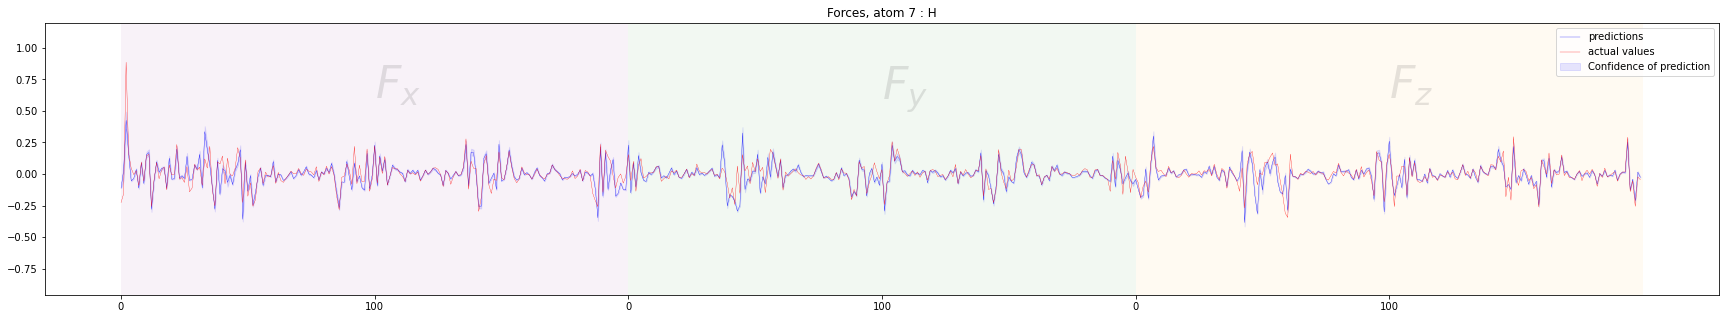

Forces MAE: 0.0334
Forces MSE: 0.0034
Cumulative uncertainty: 7.9270


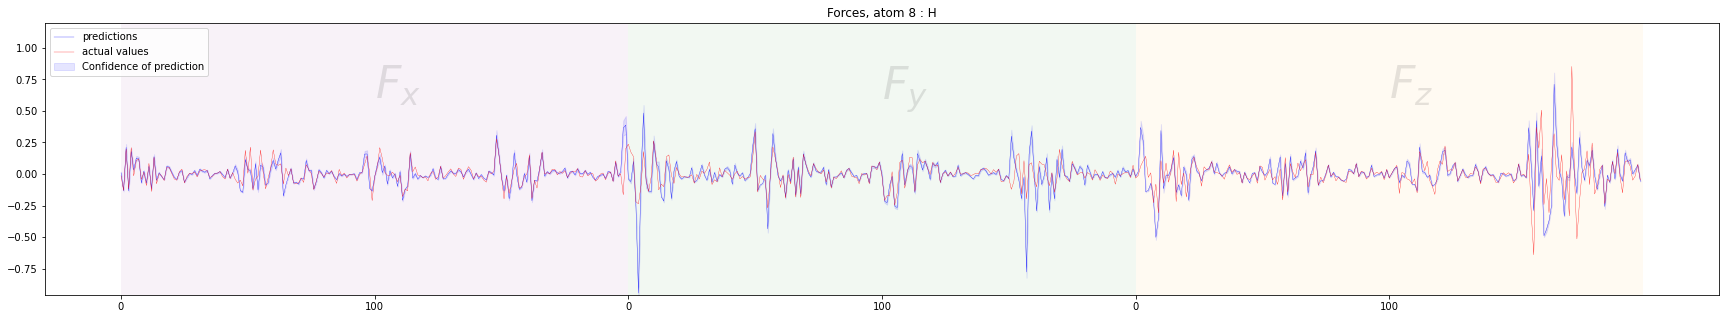

Forces MAE: 0.0474
Forces MSE: 0.0093
Cumulative uncertainty: 9.2327


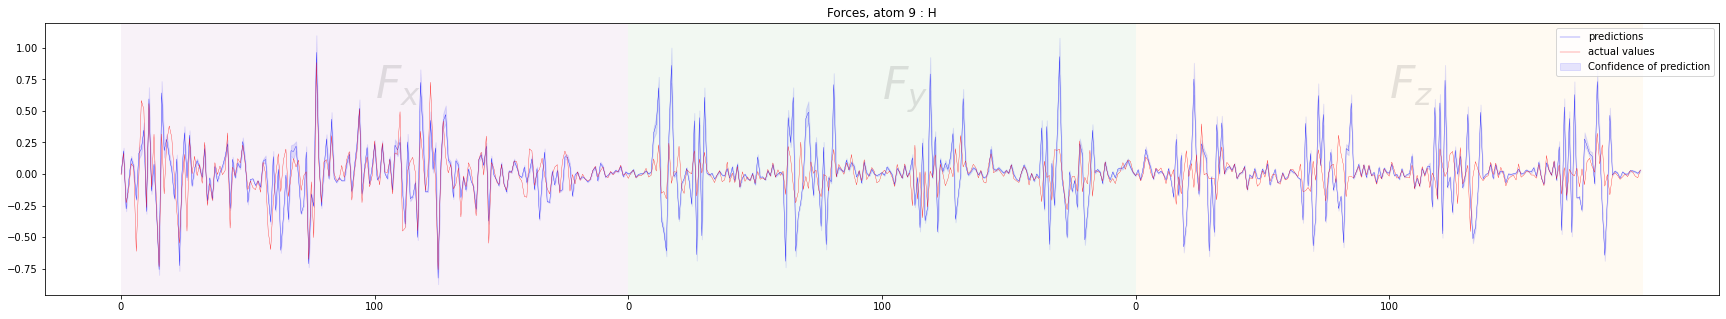

Forces MAE: 0.1216
Forces MSE: 0.0438
Cumulative uncertainty: 14.6292


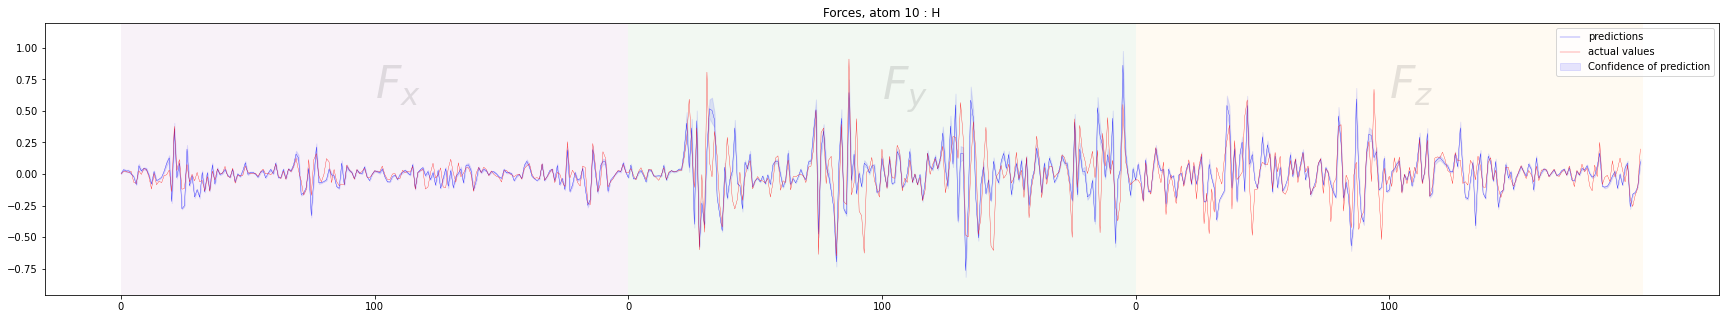

Forces MAE: 0.0808
Forces MSE: 0.0206
Cumulative uncertainty: 13.3935


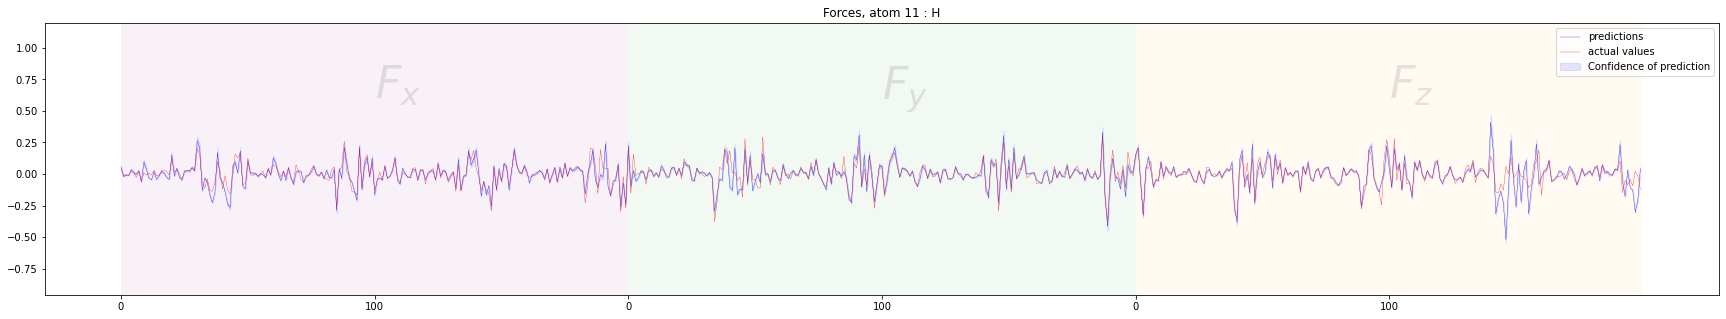

Forces MAE: 0.0331
Forces MSE: 0.0034
Cumulative uncertainty: 7.3258


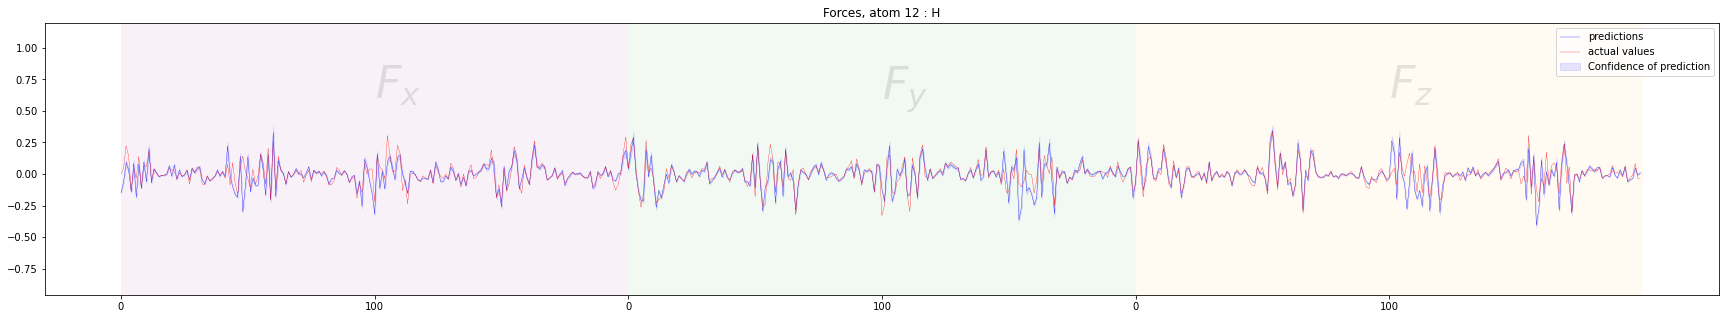

Forces MAE: 0.0364
Forces MSE: 0.0039
Cumulative uncertainty: 7.6625


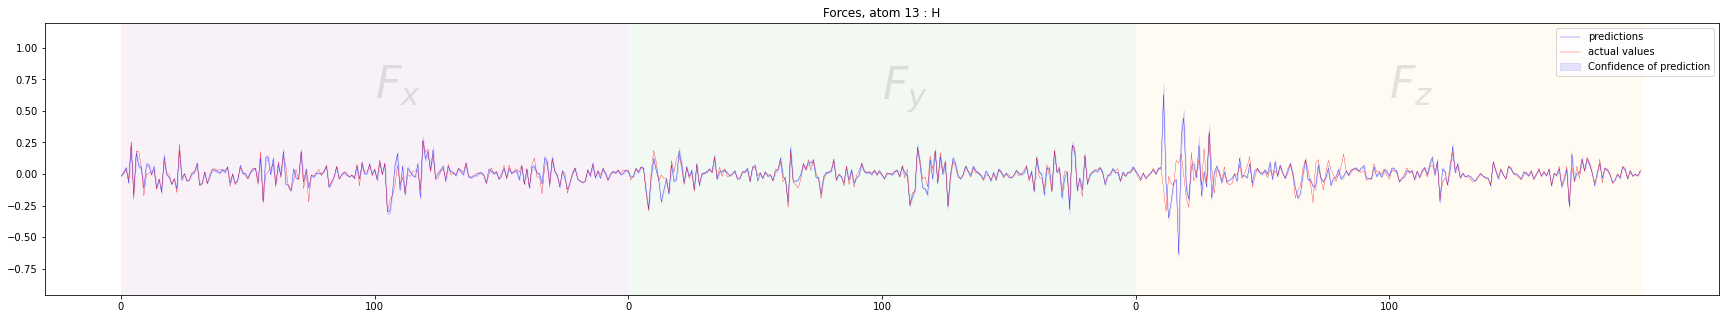

Forces MAE: 0.0279
Forces MSE: 0.0040
Cumulative uncertainty: 7.5207


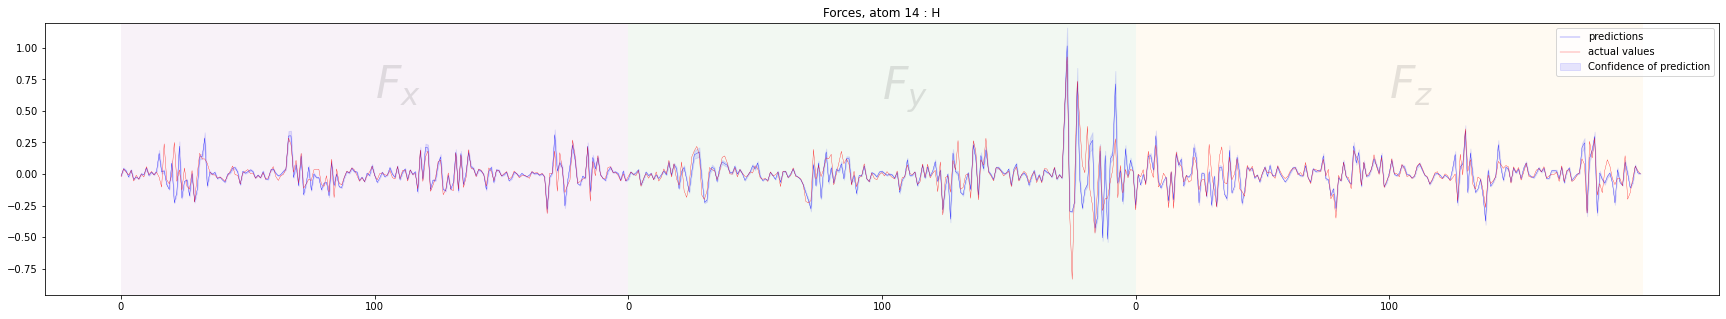

Forces MAE: 0.0408
Forces MSE: 0.0062
Cumulative uncertainty: 8.6659


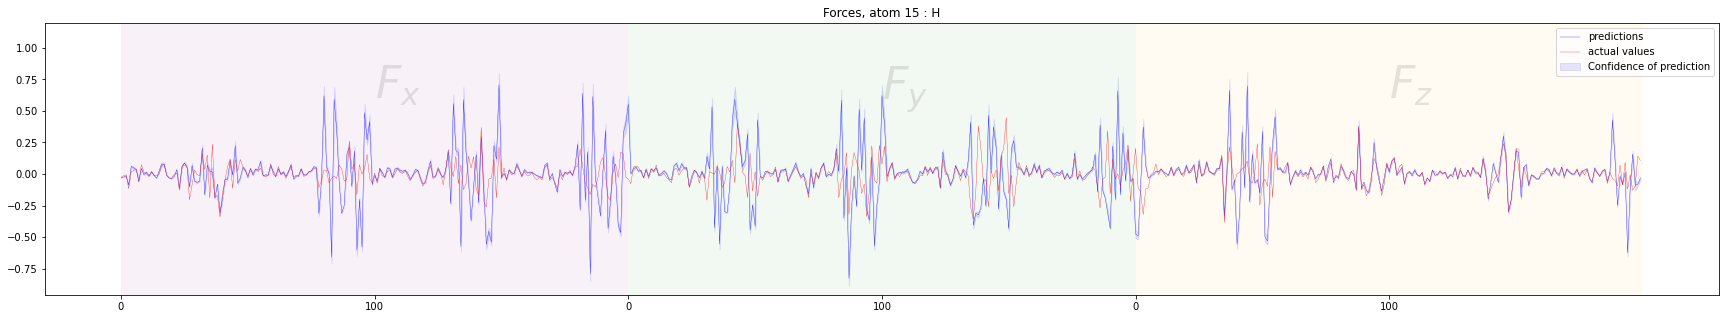

Forces MAE: 0.0993
Forces MSE: 0.0379
Cumulative uncertainty: 11.1124


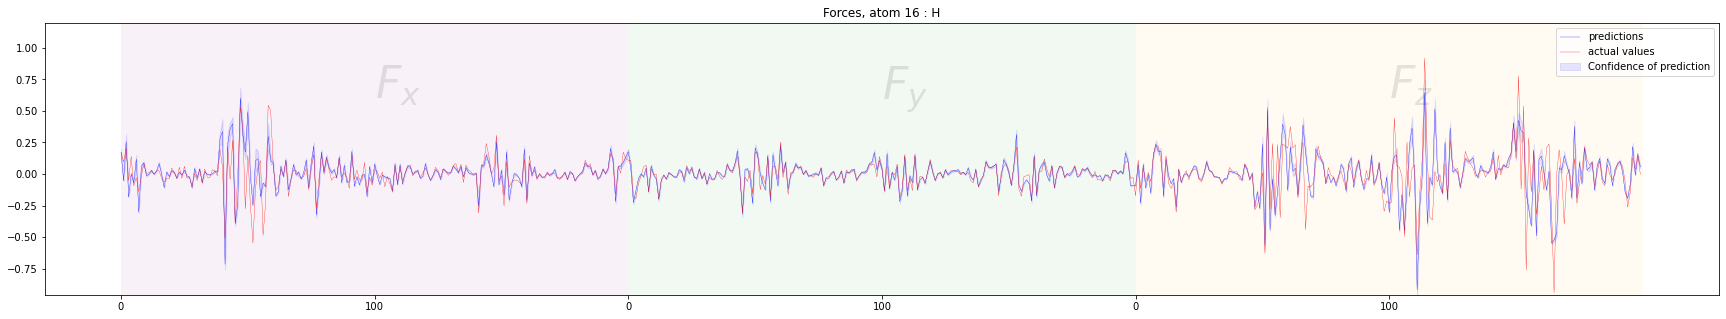

Forces MAE: 0.0568
Forces MSE: 0.0125
Cumulative uncertainty: 11.7084


In [268]:
from fande.predict import PredictorASE

test_X = fdm.test_X
test_DX = fdm.test_DX
test_E = fdm.test_E
test_F = fdm.test_F

model_e = None
trainer_e = None


predictor = PredictorASE(
            model_e,
            model_f,
            trainer_e,
            trainer_f,
            test_X,
            test_DX,
            test_E,
            test_F,
            test_data,
            hparams
)

predictor.predict_and_plot_forces()

### Dynamics simulation

In [ ]:
from sdynamics.dynamics import MDynamics

atoms = ... # initialize saddle structure

atoms.calc = gp_model.ase_calc() # get calc from the trained GP

md_runner = MDynamics(atoms) # instantiate class for running MD

md_runner.run() # run the MD

### Visualize:

In [143]:
from ase.visualize import view

# trj = trajectories[trj_files_basename[2]]
view(traj[0:100])

<Popen: returncode: None args: ['/home/dlb/anaconda3/envs/pyc/bin/python', '...>

In [277]:
forces = fdm.forces_train[0]

traj[0].set_velocities(forces)

In [279]:
traj[0].get_velocities()

array([[-3.90522999e-04,  4.68570074e-03,  2.31874938e-03],
       [-5.37185370e-03, -1.36574150e-05,  8.30739807e-04],
       [-1.22377257e-03, -1.09553763e-02,  1.36464360e-03],
       [ 9.91943761e-04,  2.55279419e-03, -3.13065246e-03],
       [-1.27218775e-03, -1.32434891e-02, -1.11857372e-02],
       [ 7.68728430e-03,  9.74544106e-03, -7.57649694e-03],
       [ 1.20865503e-03,  5.43907481e-03,  1.49617786e-02],
       [-4.34298248e-03, -2.32720331e-03, -4.19559293e-03],
       [ 1.11949766e-03,  5.79979828e-04,  3.27397193e-03],
       [ 2.66445874e-03,  1.32920409e-03,  2.88248021e-03],
       [-6.67046476e-04,  2.56271864e-03, -3.49064641e-03],
       [ 3.98590183e-04,  1.22282798e-03,  2.57228870e-03],
       [ 5.73074166e-04, -8.30302240e-04, -1.74763154e-04],
       [-2.78975580e-03, -3.40333050e-05,  6.95041153e-04],
       [-1.88000470e-03,  6.16194170e-04, -1.16993422e-04],
       [-2.85754338e-04, -1.46566614e-03,  9.43701018e-04],
       [ 3.58037696e-03,  1.35792298e-04

In [287]:
traj[0].euler_rotate(phi=25, theta=33, psi=12, center=(0, 0, 0))
traj[0].rotate(90, (0, 0, 1))

In [292]:
traj[0].get_velocities()

array([[-3.90522999e-04,  4.68570074e-03,  2.31874938e-03],
       [-5.37185370e-03, -1.36574150e-05,  8.30739807e-04],
       [-1.22377257e-03, -1.09553763e-02,  1.36464360e-03],
       [ 9.91943761e-04,  2.55279419e-03, -3.13065246e-03],
       [-1.27218775e-03, -1.32434891e-02, -1.11857372e-02],
       [ 7.68728430e-03,  9.74544106e-03, -7.57649694e-03],
       [ 1.20865503e-03,  5.43907481e-03,  1.49617786e-02],
       [-4.34298248e-03, -2.32720331e-03, -4.19559293e-03],
       [ 1.11949766e-03,  5.79979828e-04,  3.27397193e-03],
       [ 2.66445874e-03,  1.32920409e-03,  2.88248021e-03],
       [-6.67046476e-04,  2.56271864e-03, -3.49064641e-03],
       [ 3.98590183e-04,  1.22282798e-03,  2.57228870e-03],
       [ 5.73074166e-04, -8.30302240e-04, -1.74763154e-04],
       [-2.78975580e-03, -3.40333050e-05,  6.95041153e-04],
       [-1.88000470e-03,  6.16194170e-04, -1.16993422e-04],
       [-2.85754338e-04, -1.46566614e-03,  9.43701018e-04],
       [ 3.58037696e-03,  1.35792298e-04